In [13]:
import os
import numpy as np
import pandas as pd
import random
from PIL import Image , ImageEnhance

#keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense , Flatten , Dropout
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [56]:
# Define paths
train_dir = "/home/shreesha/Downloads/MRI Images/Training"
test_dir = "/home/shreesha/Downloads/MRI Images/Testing"


# loading and shuffling the train data 
train_paths = []
train_labels = []
 
for label in os.listdir(train_dir):
    for image in os.listdir(os.path.join(train_dir , label)):
        train_paths.append(os.path.join(train_dir,label,image))
        train_labels.append(label)

train_paths , train_labels = shuffle(train_paths,train_labels)

# loading and shuffling the train data 
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(os.path.join(test_dir , label)):
        test_paths.append(os.path.join(test_dir,label,image))
        test_labels.append(label)

test_paths , test_labels = shuffle(test_paths,test_labels)

# DATA VISUALISATION

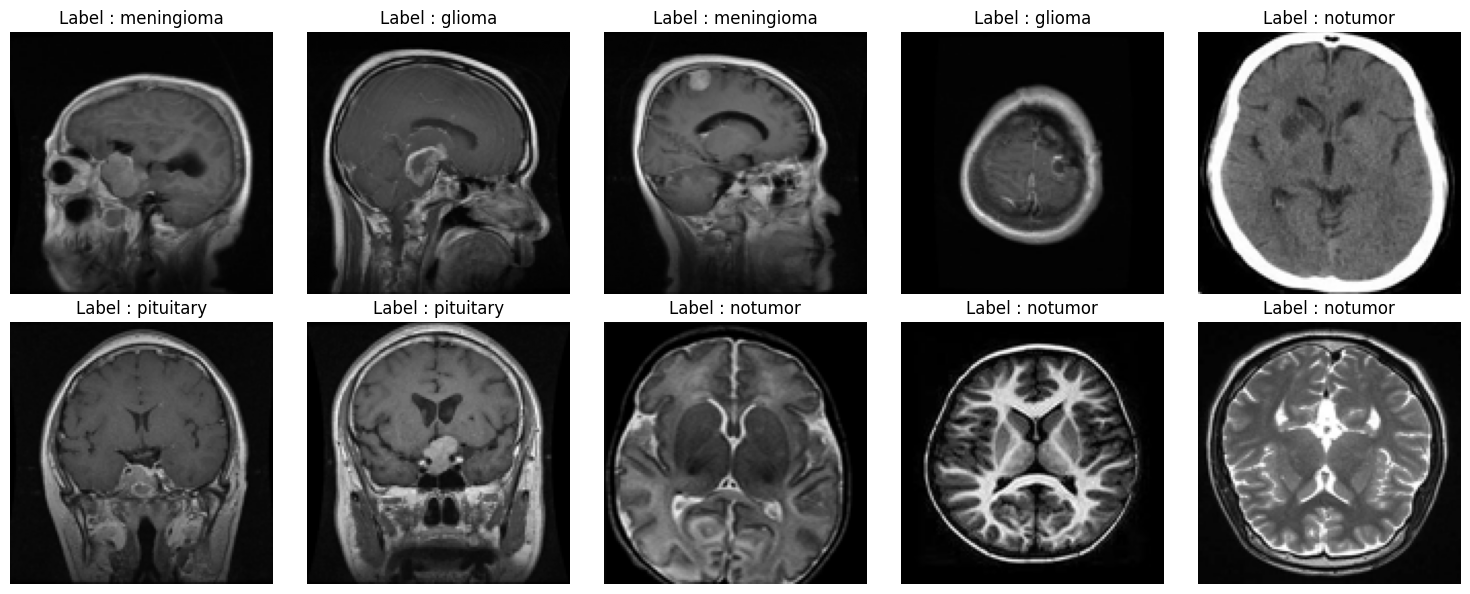

In [53]:
import matplotlib.pyplot as plt

#selecting random 10 indices 
random_indices = random.sample(range(len(train_paths)),10)

fig , axes = plt.subplots(2 , 5 , figsize=(15,6))
axes = axes.ravel()
# `axes.ravel()` flattens the 2D array of subplots into 1D, so you can loop easily with `axes[i]`. Without it, you'd get an indexing error.

for i , idx in enumerate(random_indices):
    img_path = train_paths[idx]
    img = Image.open(img_path)
    img = img.resize((128,128))
    axes[i].imshow(img , cmap='gray')
    axes[i].axis("off")
    axes[i].set_title(f"Label : {train_labels[idx]}")
plt.tight_layout()

 # IMAGE PREPROCESSING

In [58]:
# Image Augmentation function
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))  # Random brightness
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))  # Random contrast
    image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
    return image

# Load images and apply augmentation
def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

# Encoding labels (convert label names to integers)
def encode_label(labels):
    unique_labels = os.listdir(train_dir)  # Ensure unique labels are determined
    encoded = [unique_labels.index(label) for label in labels]
    return np.array(encoded)

# Data generator for batching
def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_images = open_images(batch_paths)  # Open and augment images
            batch_labels = labels[i:i + batch_size]
            batch_labels = encode_label(batch_labels)  # Encode labels
            yield batch_images, batch_labels  # Yield the batch

# MODEL

In [59]:

# Set image size and input shape
IMAGE_SIZE = 128
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)

# Load VGG16 base model (without top classifier)
base_model = VGG16(input_shape=input_shape, include_top=False, weights='imagenet')

# Freeze all layers initially
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze only the last few layers for fine-tuning
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

# Build the model
model = Sequential()
model.add(Input(shape=input_shape))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(os.listdir(train_dir)), activation='softmax'))

# Compile
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',  # fixed typo here
    metrics=['sparse_categorical_accuracy']
)

# Set training parameters
batch_size = 20
steps = len(train_paths) // batch_size
epochs = 5

# Train the model
# You must define 'datagen' earlier as a generator that yields (image, label) batches
history = model.fit(
    datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
    steps_per_epoch=steps,
    epochs=epochs
)

Epoch 1/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 212s 736ms/step - loss: 0.6666 - sparse_categorical_accuracy: 0.7372
Epoch 2/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 204s 717ms/step - loss: 0.2468 - sparse_categorical_accuracy: 0.9065
Epoch 3/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 205s 719ms/step - loss: 0.1471 - sparse_categorical_accuracy: 0.9459
Epoch 4/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 206s 722ms/step - loss: 0.1111 - sparse_categorical_accuracy: 0.9548
Epoch 5/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 230s 806ms/step - loss: 0.0838 - sparse_categorical_accuracy: 0.9704


# Train and Val Plots

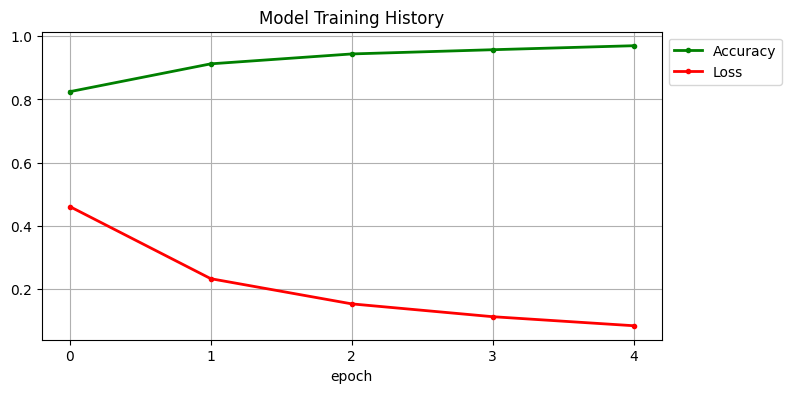

In [60]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

# Model Classification Report

In [67]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model
import numpy as np

# 1. Prediction on test data
test_images = open_images(test_paths)  # Load and augment test images
test_labels_encoded = encode_label(test_labels)  # Encode the test labels

# Predict using the trained model
test_predictions = model.predict(test_images)

# 2. Classification Report
print("Classification Report:")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))

41/41 ━━━━━━━━━━━━━━━━━━━━ 33s 795ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       405
           1       0.96      0.98      0.97       300
           2       0.92      0.94      0.93       306
           3       0.99      0.92      0.95       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311



# Model Confusion Plot

Confusion Matrix:
[[404   0   0   1]
 [  1 295   3   1]
 [  6   9 289   2]
 [  0   2  23 275]]


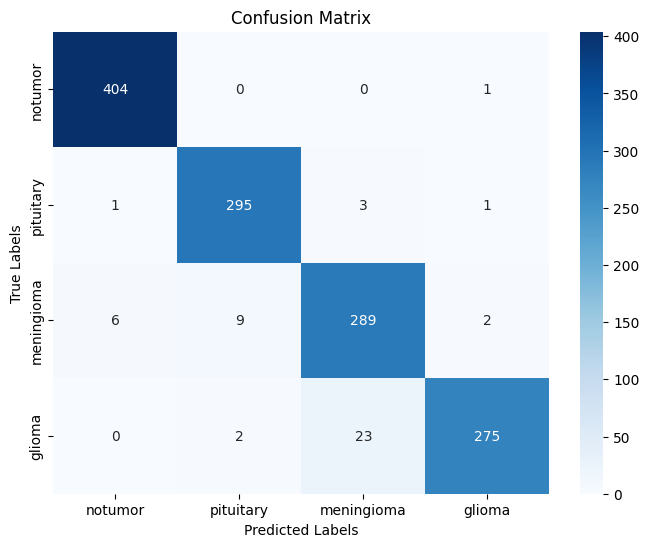

In [68]:
# 3. Confusion Matrix
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))
print("Confusion Matrix:")
print(conf_matrix)

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=os.listdir(train_dir), yticklabels=os.listdir(train_dir))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Roc Curve Plot

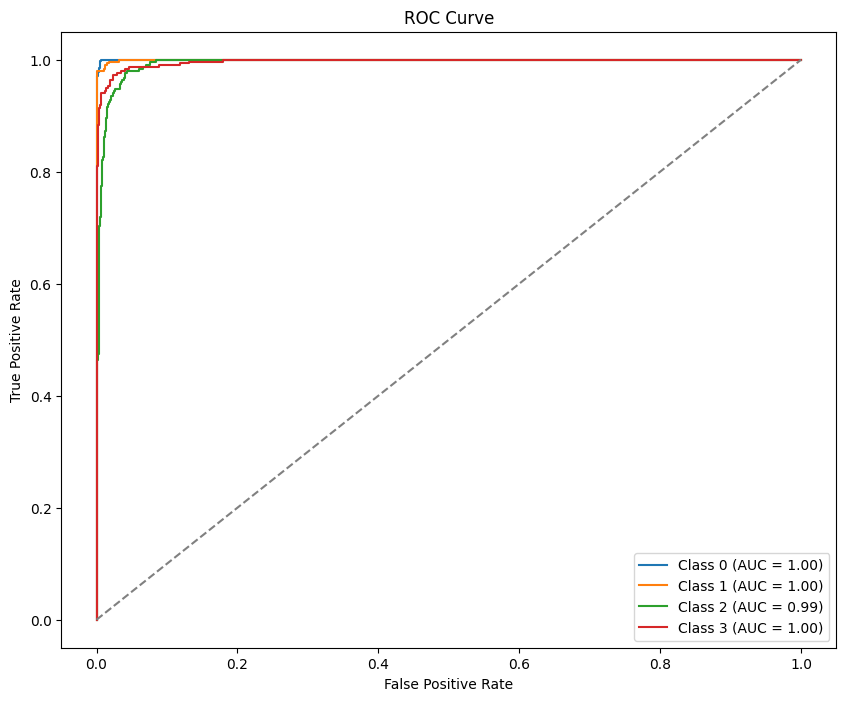

In [70]:
# 4. ROC Curve and AUC
# Binarize the test labels and predictions for multi-class ROC
test_labels_bin = label_binarize(test_labels_encoded, classes=np.arange(len(os.listdir(train_dir))))
test_predictions_bin = test_predictions  # The predicted probabilities for each class

# Compute ROC curve and ROC AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(os.listdir(train_dir))):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(len(os.listdir(train_dir))):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

# Save & Load Model

In [71]:
model.save('model.h5')

In [72]:
from tensorflow.keras.models import load_model
# Load the trained model
model = load_model('model.h5')

# MRI Tumor Detection System


In [73]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Class labels
class_labels = ['pituitary', 'glioma', 'notumor', 'meningioma']

def detect_and_display(img_path, model, image_size=128):
    """
    Function to detect tumor and display results.
    If no tumor is detected, it displays "No Tumor".
    Otherwise, it shows the predicted tumor class and confidence.
    """
    try:
        # Load and preprocess the image
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Make a prediction
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        confidence_score = np.max(predictions, axis=1)[0]

        # Determine the class
        if class_labels[predicted_class_index] == 'notumor':
            result = "No Tumor"
        else:
            result = f"Tumor: {class_labels[predicted_class_index]}"

        # Display the image with the prediction
        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()

    except Exception as e:
        print("Error processing the image:", str(e))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


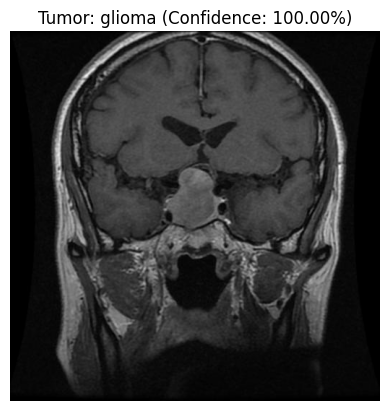

In [77]:
# Example usage
image_path =  '/home/shreesha/Downloads/MRI Images/Testing/pituitary/Te-pi_0204.jpg' # Provide the path to your new image
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


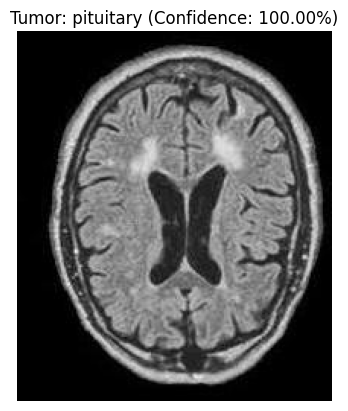

In [79]:
# Example usage
image_path =   '/home/shreesha/Downloads/MRI Images/Testing/notumor/Te-no_0187.jpg' # Provide the path to your new image
detect_and_display(image_path, model)
